## Trying out a linear model: 

Author: Alexandru Papiu ([@apapiu](https://twitter.com/apapiu), [GitHub](https://github.com/apapiu))
 
If you use parts of this notebook in your own scripts, please give some sort of credit (for example link back to this). Thanks!


There have been a few [great](https://www.kaggle.com/comartel/house-prices-advanced-regression-techniques/house-price-xgboost-starter/run/348739)  [scripts](https://www.kaggle.com/zoupet/house-prices-advanced-regression-techniques/xgboost-10-kfolds-with-scikit-learn/run/357561) on [xgboost](https://www.kaggle.com/tadepalli/house-prices-advanced-regression-techniques/xgboost-with-n-trees-autostop-0-12638/run/353049) already so I'd figured I'd try something simpler: a regularized linear regression model. Surprisingly it does really well with very little feature engineering. The key point is to to log_transform the numeric variables since most of them are skewed.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


#%config InlineBackend.figure_format = 'retina' 
#set 'png' here when working on notebook
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [5]:
all_data.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


###Data preprocessing: 
We're not going to do anything fancy here: 
 
- First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal    
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac59931150>,
      dtype=object)

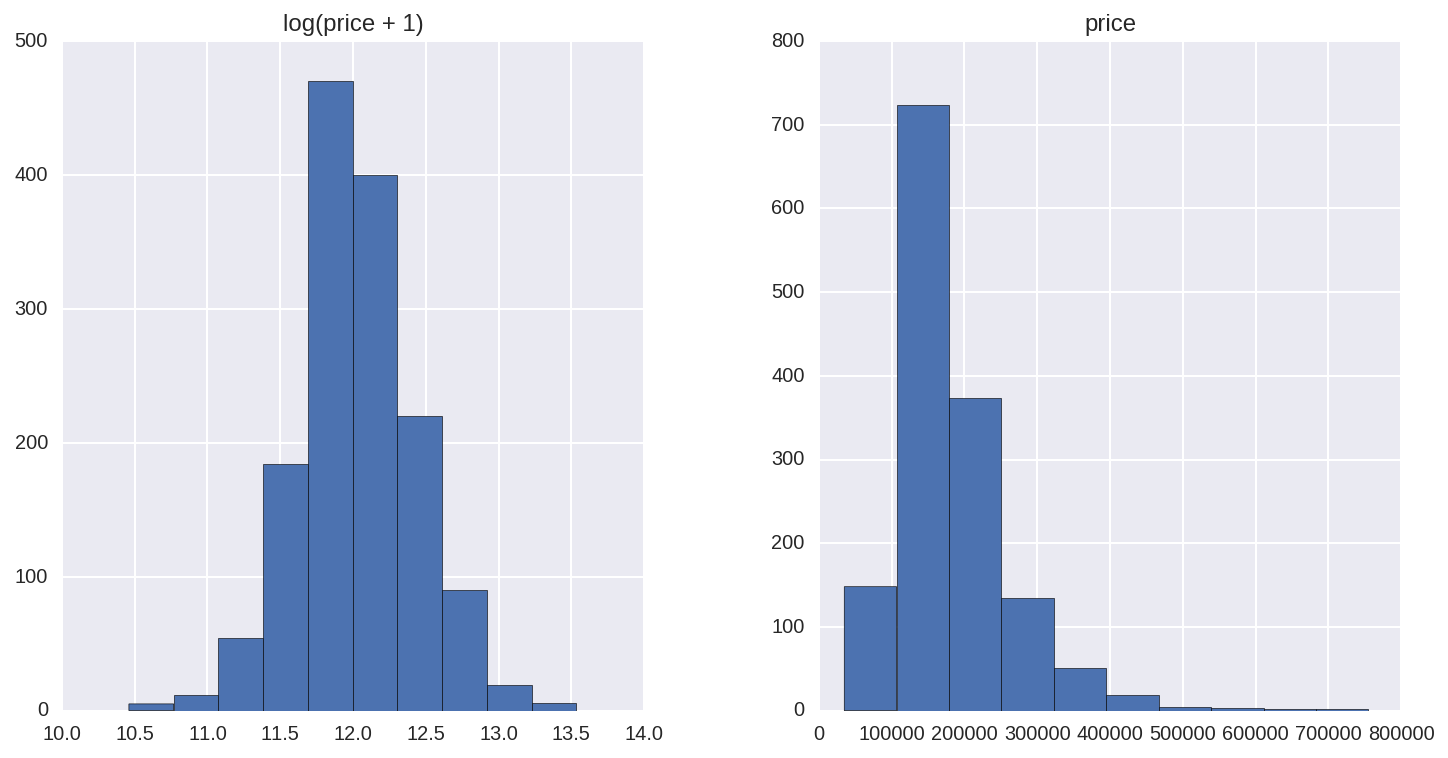

In [7]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], 
                       "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [8]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) 
#compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [9]:
all_data = pd.get_dummies(all_data)

In [10]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [11]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

###Models

Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [12]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, 
                            scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [13]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [14]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

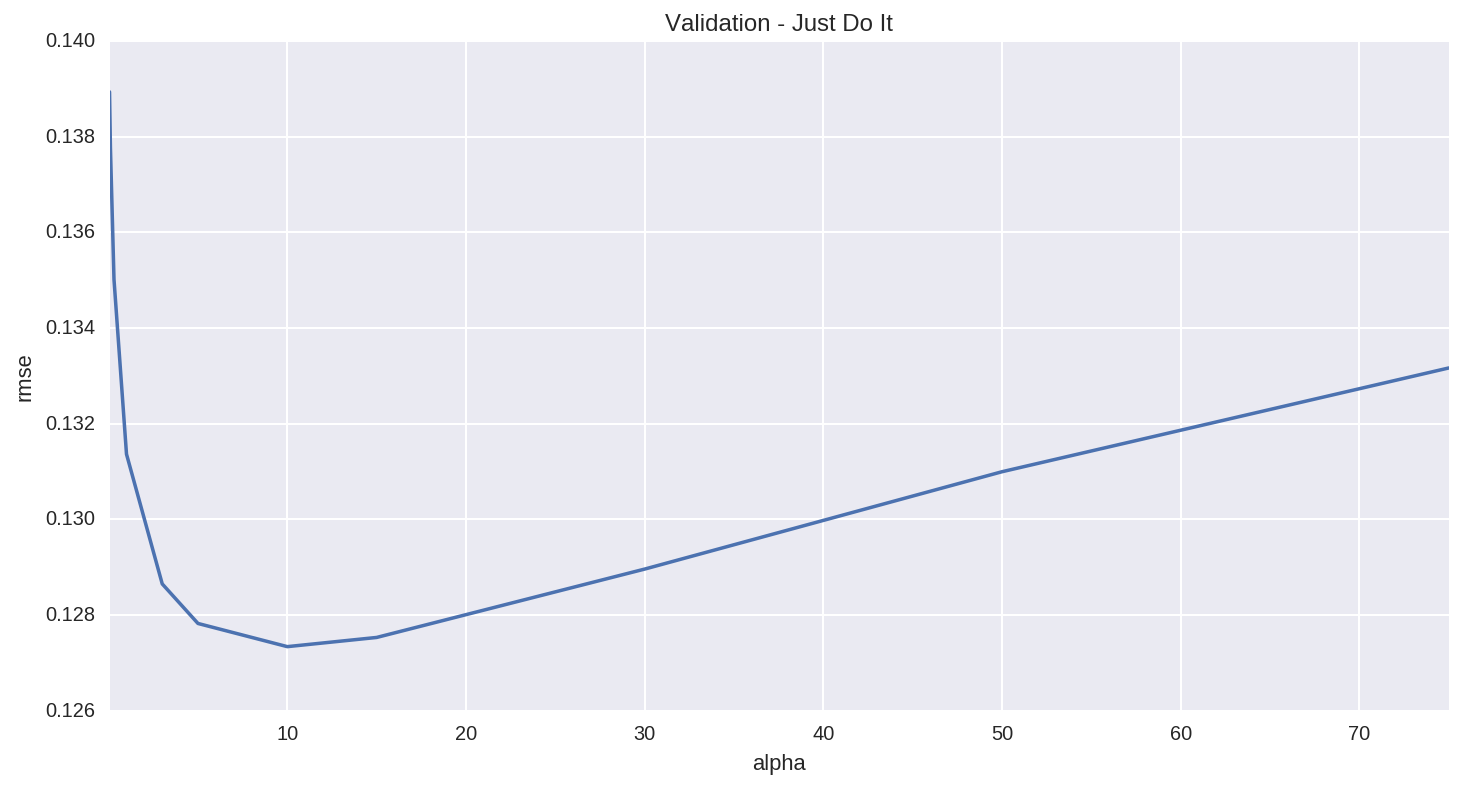

In [15]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [16]:
cv_ridge.min()

0.12733734668670765

So for the Ridge regression we get a rmsle of about 0.127

Let' try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

In [17]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [18]:
rmse_cv(model_lasso).mean()

0.1231442109097745

Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [19]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [20]:
print("Lasso picked " + str(sum(coef != 0)) + 
      " variables and eliminated the other " +  
      str(sum(coef == 0)) + " variables")

Lasso picked 111 variables and eliminated the other 177 variables


Good job Lasso.  One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

In [21]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

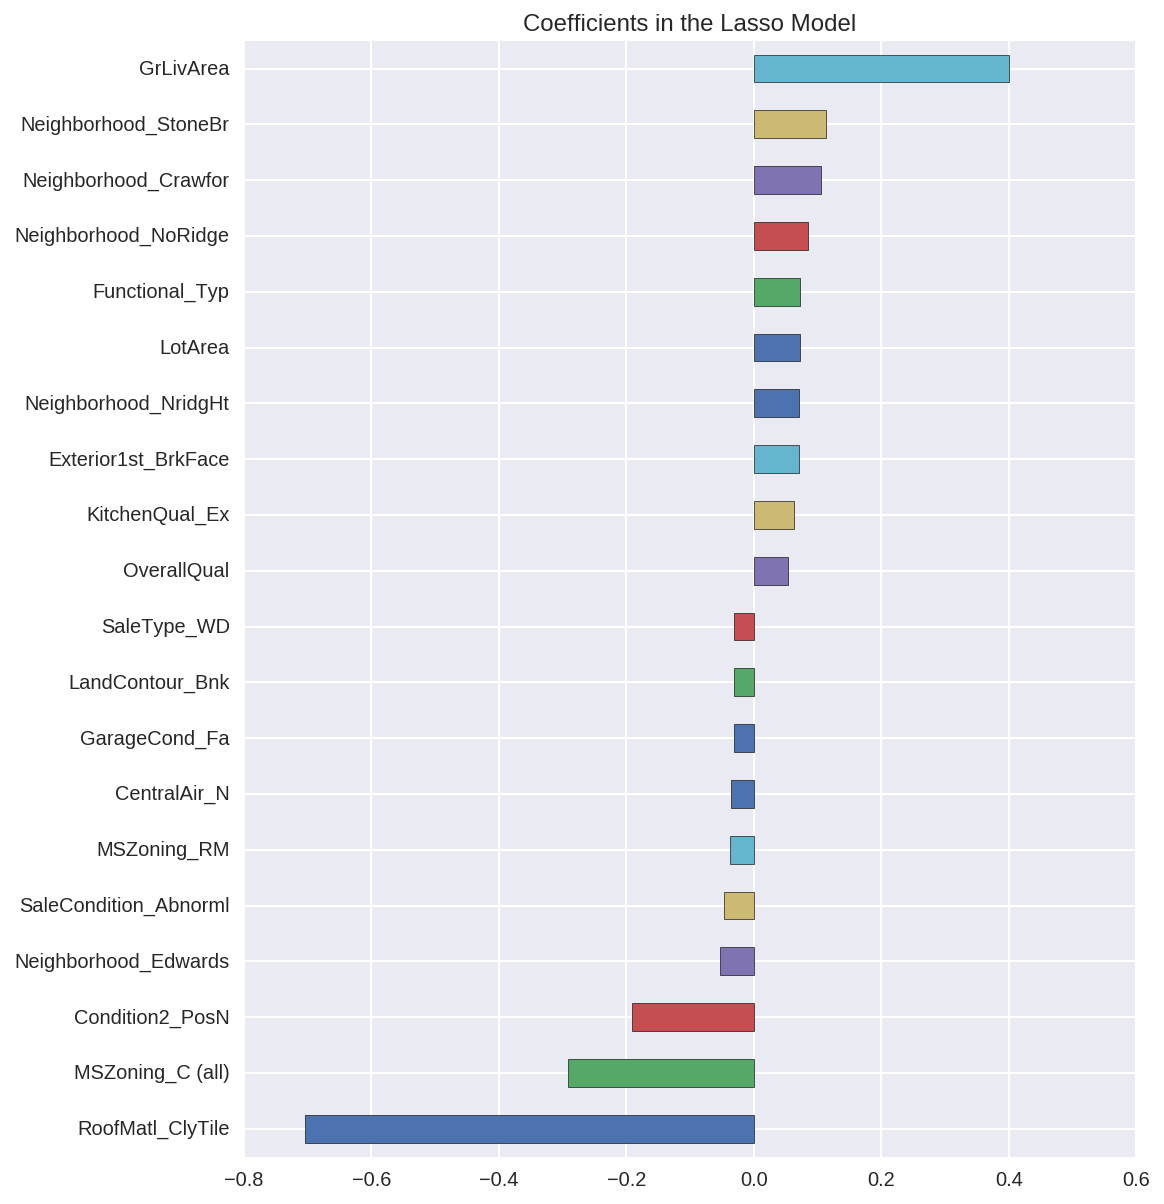

In [22]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

The most important positive feature is `GrLivArea` -  the above ground area by area square feet. This definitely sense. Then a few other  location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

 Also note that unlike the feature importance you'd get from a random forest these are _actual_ coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret. 

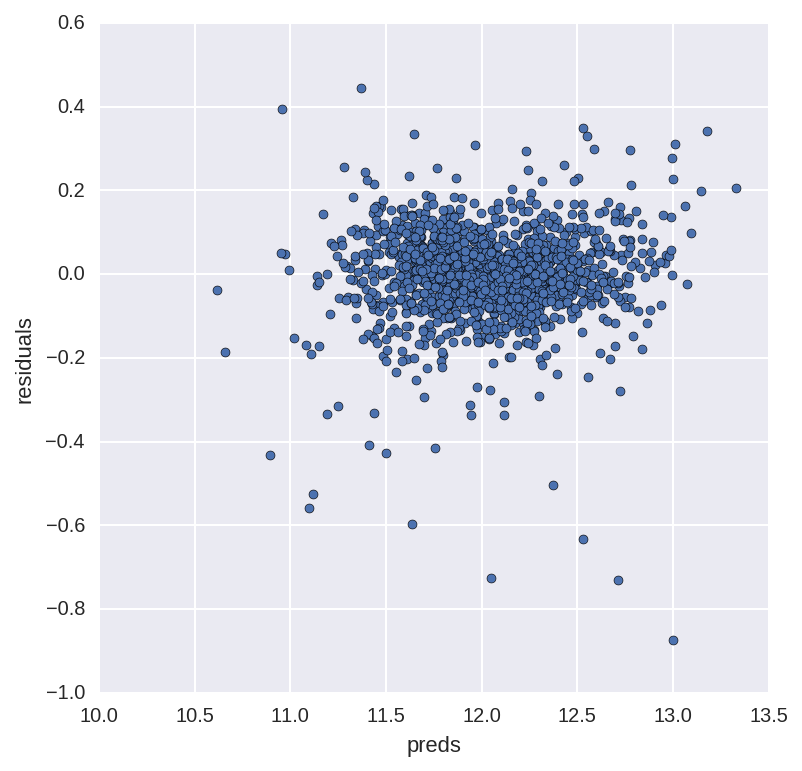

In [23]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

The residual plot looks pretty good.To wrap it up let's predict on the test set and submit on the leaderboard:

### Adding an xgboost model:

Let's add an xgboost model to our linear model to see if we can improve our score:

In [25]:
import xgboost as xgb

In [26]:

dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

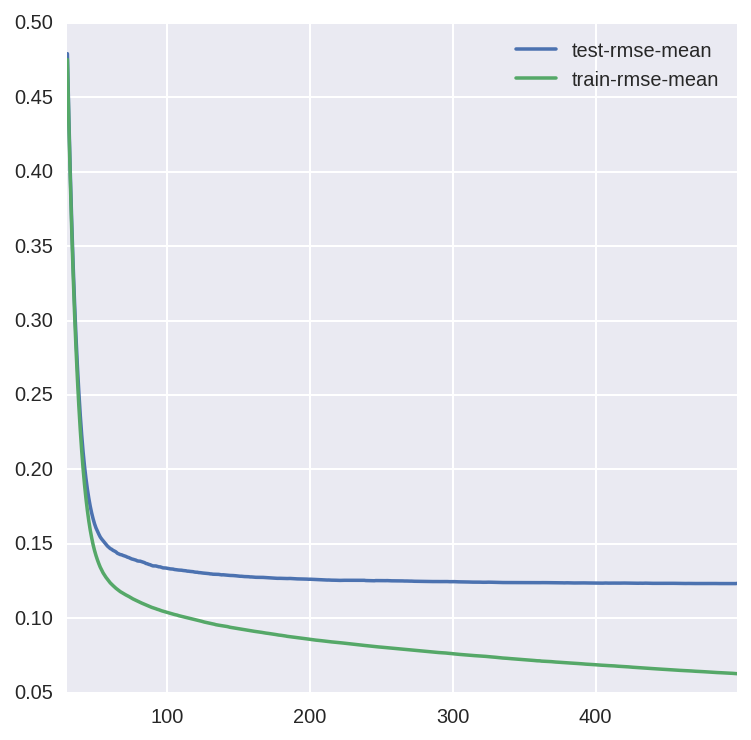

In [27]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [28]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) 
#the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [29]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

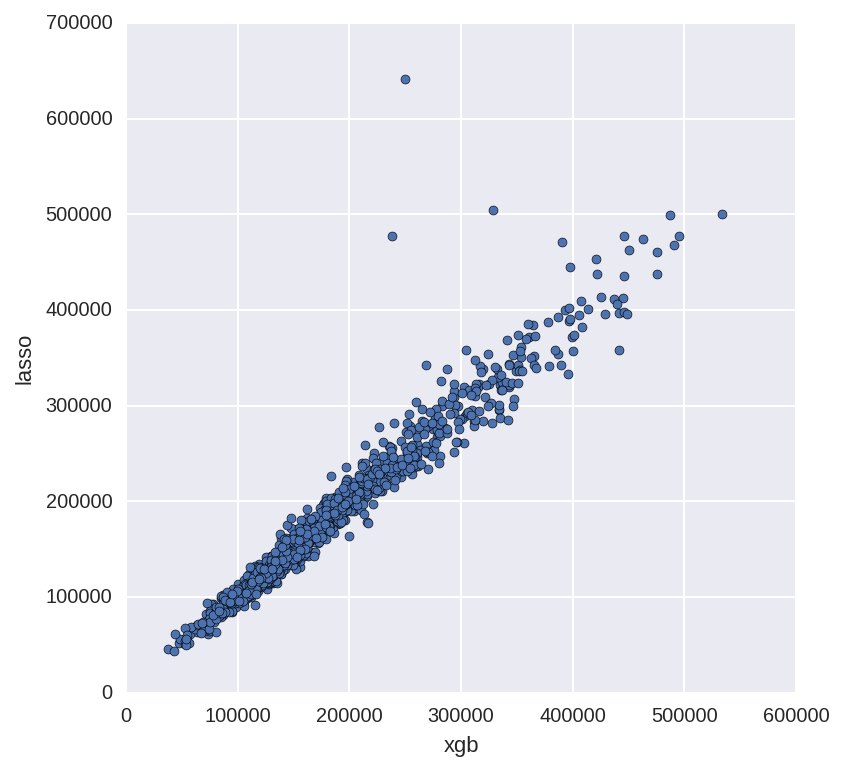

In [30]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves the score although in this case it doesn't help that much.

In [31]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [32]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

### Trying out keras?

Feedforward Neural Nets doesn't seem to work well at all...I wonder why.

In [33]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

/usr/lib64/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [34]:
X_train = StandardScaler().fit_transform(X_train)

In [35]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [36]:
X_tr.shape

(1095, 288)

In [37]:
X_tr

array([[ 1.00573733,  0.68066137, -0.46001991, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184,  0.60296111,  0.03113183, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184, -0.02865265, -0.74027492, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ...,
       [ 0.16426234, -0.87075036, -0.81954431, ..., -0.11785113,
        -2.13834494, -0.30599503],
       [ 0.92361154, -0.30038284, -0.44275864, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.83656519,  1.98505948,  0.46455838, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [38]:
model = Sequential()
#model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))

model.compile(loss = "mse", optimizer = "adam")

/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_regularizer=<keras.reg..., input_dim=288)`
  app.launch_new_instance()


In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [40]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

Train on 1095 samples, validate on 365 samples
Epoch 1/1

1095/1095 [==============================] - 0s 90us/step - loss: 147.0312 - val_loss: 149.9484


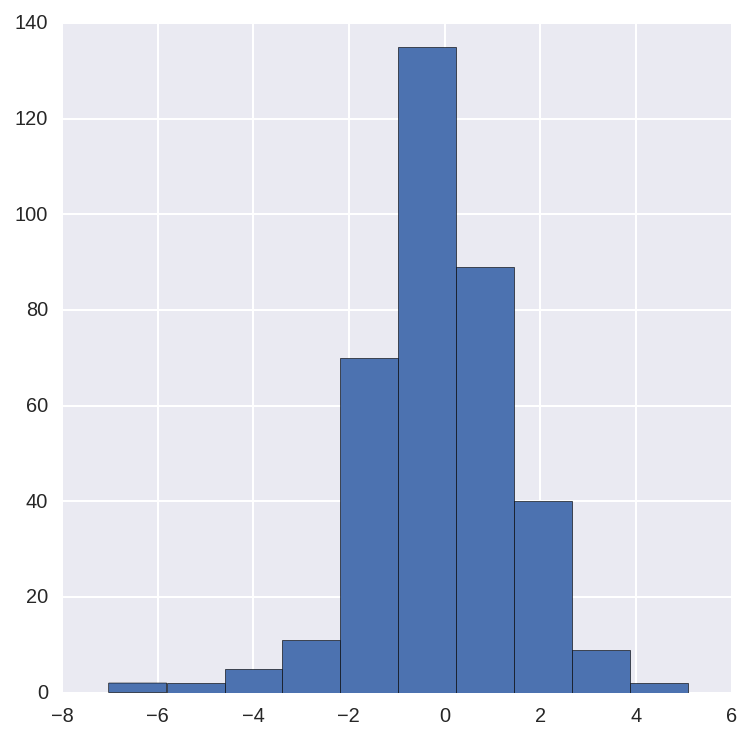

In [41]:
pd.Series(model.predict(X_val)[:,0]).hist()